<a href="https://colab.research.google.com/github/dctian/DeepPiCar/blob/master/models/lane_navigation/code/end_to_end_lane_navigation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-End Lane Navigation via Nvidia Model
Author: David Tian

Date: 2019-05-01

This is model training portion of [DeepPiCar - Part 5: Autonomous Lane Navigation via Deep Learning](https://medium.com/@dctian/deeppicar-part-5-lane-following-via-deep-learning-d93acdce6110?source=your_stories_page---------------------------) Blog.   Please check out that blog for the full explanation of the code below. 

In [2]:
model_output_dir = '/Users/tin/AiTestVenv311/test_output_2'

In [3]:
#################### SEND ALERT EMAIL AT FINISH WITH GMAIL #####################
# To send email from Python from your google account, MUST 
# 1) Enable less secure app
# https://myaccount.google.com/lesssecureapps
# 2) Disable Unlock Capcha
# https://accounts.google.com/b/0/DisplayUnlockCaptcha

import smtplib

def SendEmail(msg):
    print(f'Email Stub: \n{msg}')

## Imports Packages

In [4]:
# imports

# python standard libraries
import os
import random
import fnmatch
import datetime
import pickle

# data processing
import numpy as np
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})

import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

# tensorflow
import tensorflow as tf
import keras
from keras.models import Sequential  # V2 is tensorflow.keras.xxxx, V1 is keras.xxx
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization
from keras.optimizers import Adam
from keras.models import load_model

num_threads = 16
os.environ["OMP_NUM_THREADS"] = "16"
os.environ["TF_NUM_INTRAOP_THREADS"] = "16"
os.environ["TF_NUM_INTEROP_THREADS"] = "16"

tf.config.threading.set_inter_op_parallelism_threads(
    num_threads
)
tf.config.threading.set_intra_op_parallelism_threads(
    num_threads
)

print( f'tf.__version__: {tf.__version__}' )
print( f'keras.__version__: {keras.__version__}' )

# sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# imaging
import cv2
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image


tf.__version__: 2.16.2
keras.__version__: 3.8.0


## Load Train Data

image_path: /Users/tin/AiTestVenv311/test_dataset_2/IMG0332_481_54.jpg
steering_Angle: 54


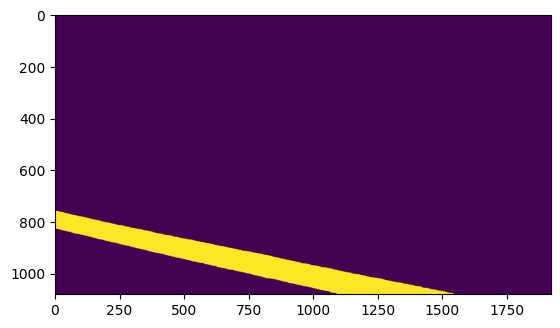

In [5]:
# import images

data_dir = '/Users/tin/AiTestVenv311/test_dataset_2/'
file_list = os.listdir(data_dir)
image_paths = []
steering_angles = []
pattern = "*.jpg"
for filename in file_list:
    if fnmatch.fnmatch(filename, pattern):
        image_paths.append(os.path.join(data_dir,filename))
        angle = int(filename.split('_')[2].split(".")[0]) # IMG0321_1_90.jpg
        steering_angles.append(angle)

image_index = 20
plt.imshow(Image.open(image_paths[image_index]))
print("image_path: %s" % image_paths[image_index] )
print("steering_Angle: %d" % steering_angles[image_index] )
df = pd.DataFrame()
df['ImagePath'] = image_paths
df['Angle'] = steering_angles


(array([7.0000, 4.0000, 50.0000, 1.0000, 0.0000, 4.0000, 2.0000, 3.0000,
        4.0000, 2.0000, 29.0000, 50.0000, 144.0000, 54.0000, 54.0000,
        26.0000, 1.0000, 1.0000, 1.0000, 3.0000, 0.0000, 0.0000, 0.0000,
        23.0000, 10.0000]),
 array([47.0000, 50.3200, 53.6400, 56.9600, 60.2800, 63.6000, 66.9200,
        70.2400, 73.5600, 76.8800, 80.2000, 83.5200, 86.8400, 90.1600,
        93.4800, 96.8000, 100.1200, 103.4400, 106.7600, 110.0800, 113.4000,
        116.7200, 120.0400, 123.3600, 126.6800, 130.0000]),
 <BarContainer object of 25 artists>)

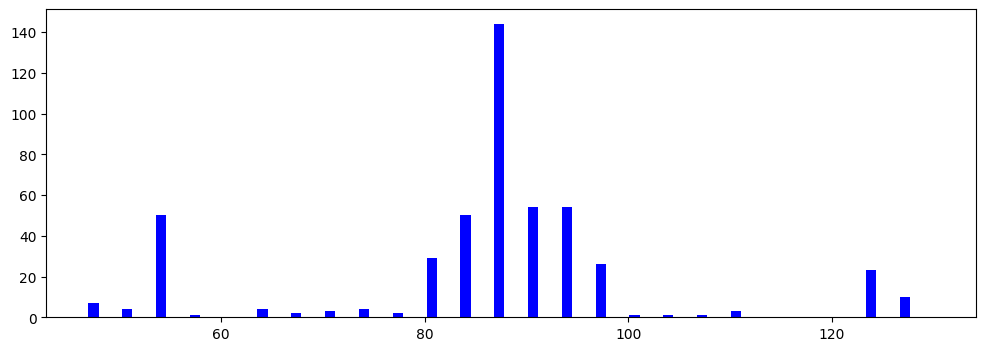

In [6]:
# Look at the distribution of steering angle
num_of_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(df['Angle'], num_of_bins)

fig, axes = plt.subplots(1,1, figsize=(12,4))
axes.hist(df['Angle'], bins=num_of_bins, width=1, color='blue')

Notice that the above diagram contains angeles mostly smaller than 90.  This makes sense, because in our training data, The car was mostly turning left.  This is going to fine, because we will balance the data by randomly flip the image, and the steering angle in the image generator process.

Training data: 378
Validation data: 95


Text(0.5, 1.0, 'Validation Data')

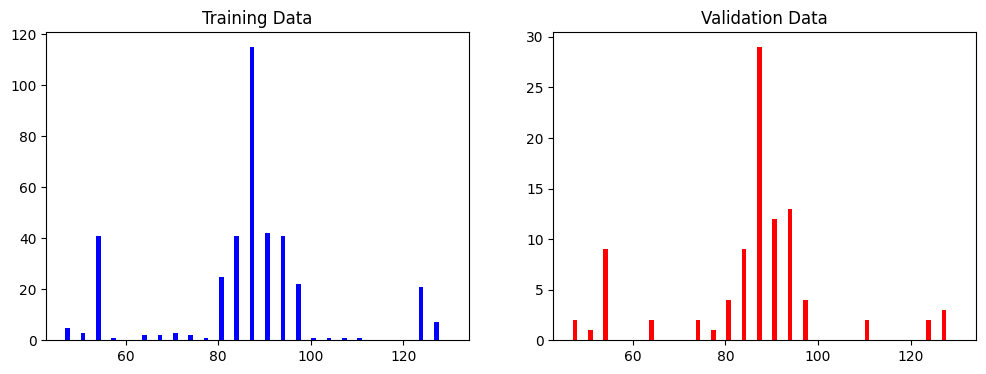

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split( image_paths, steering_angles, test_size=0.2)
print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_valid)))

# plot the distributions of train and valid, make sure they are consistent
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(y_train, bins=num_of_bins, width=1, color='blue')
axes[0].set_title('Training Data')
axes[1].hist(y_valid, bins=num_of_bins, width=1, color='red')
axes[1].set_title('Validation Data')


##Image Augumentation
Since we only have a few hundred images, to train a deep network, we need a lot more images.   Instead of running our car, let's try to augment our data. There are a couple of ways to do that.

1. Zoom: crop out a smaller image from the center
1. Pan: crop out a smaller image from left or right side
1. adjust brightness of the image
1. flip the image horizontally, i.e do a left to right flip, and change the steering angle coorespondingly
1. introduce an Gaussian blur

We can combine the above augmentation techniques to generate 100s times of the training images, with just a few hundred real images.



Text(0.5, 1.0, 'zoomed')

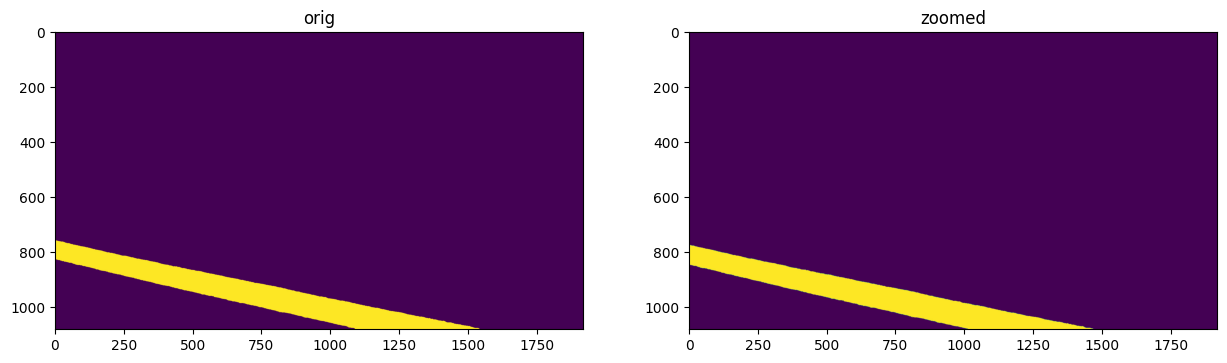

In [8]:
def my_imread(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image

def zoom(image):
    zoom = img_aug.Affine(scale=(1, 1.3))  # zoom from 100% (no zoom) to 130%
    image = zoom.augment_image(image)
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_zoom = zoom(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_zoom)
axes[1].set_title("zoomed")


Text(0.5, 1.0, 'panned')

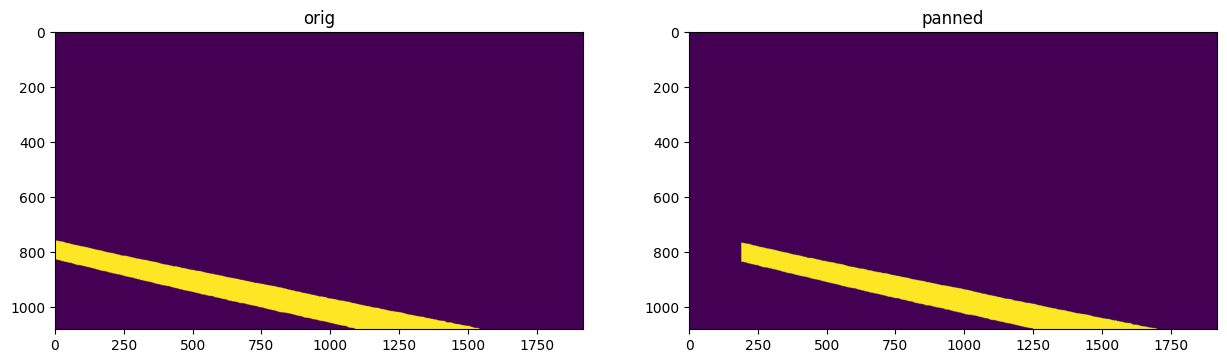

In [9]:
def pan(image):
    # pan left / right / up / down about 10%
    pan = img_aug.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_pan = pan(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_pan)
axes[1].set_title("panned")


Text(0.5, 1.0, 'brightness adjusted')

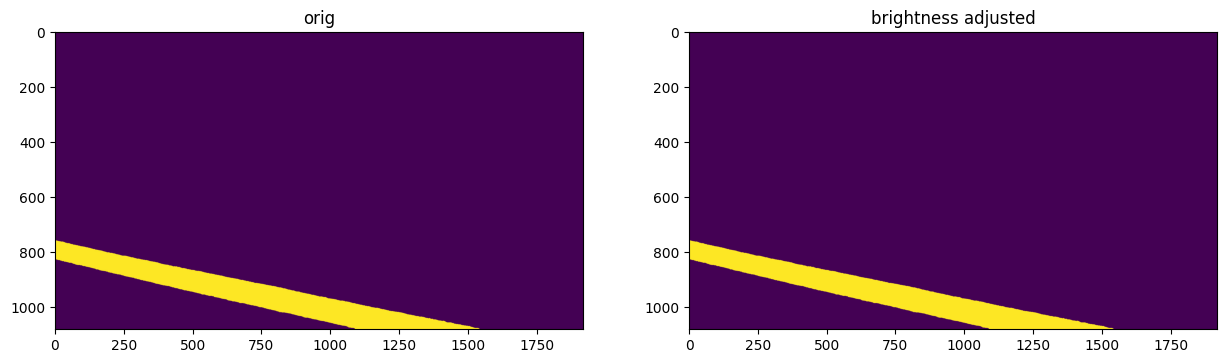

In [10]:
def adjust_brightness(image):
    # increase or decrease brightness by 30%
    brightness = img_aug.Multiply((0.7, 1.3))
    image = brightness.augment_image(image)
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_brightness = adjust_brightness(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_brightness)
axes[1].set_title("brightness adjusted")

Text(0.5, 1.0, 'blurred')

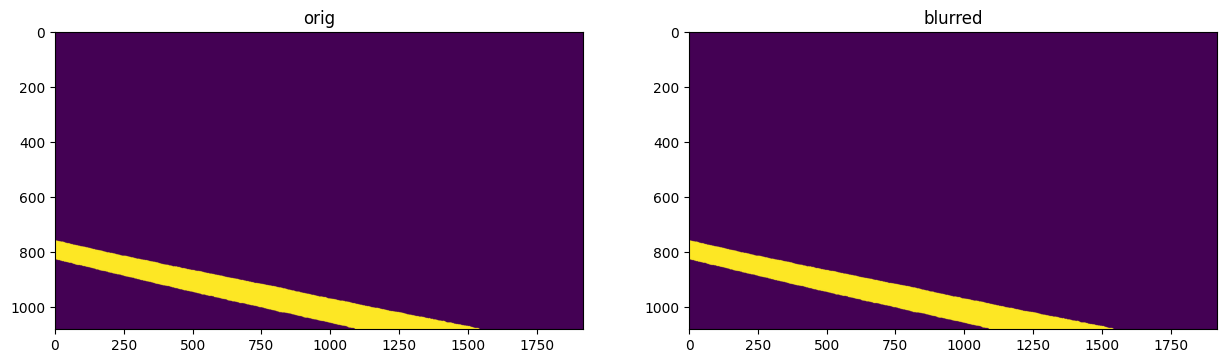

In [11]:
def blur(image):
    kernel_size = random.randint(1, 5)  # kernel larger than 5 would make the image way too blurry
    image = cv2.blur(image,(kernel_size, kernel_size))
   
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_blur = blur(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_blur)
axes[1].set_title("blurred")

Text(0.5, 1.0, 'flipped, angle=126')

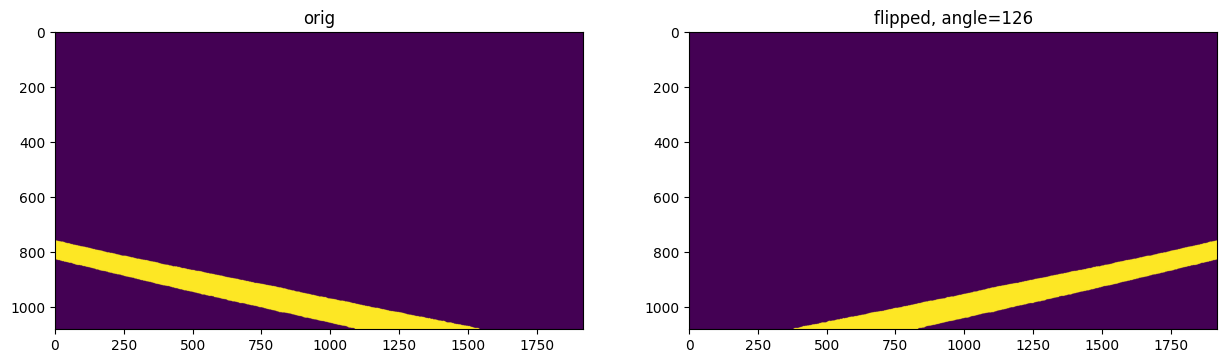

In [12]:
def random_flip(image, steering_angle):
    is_flip = random.randint(0, 1)
    if is_flip == 1:
        # randomly flip horizon
        image = cv2.flip(image,1)
        if steering_angle != 1:
            steering_angle = 180 - steering_angle
   
    return image, steering_angle

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_flip, steering_angle = random_flip(image_orig, steering_angles[image_index])
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_flip)
axes[1].set_title("flipped, angle=%s" % steering_angle)

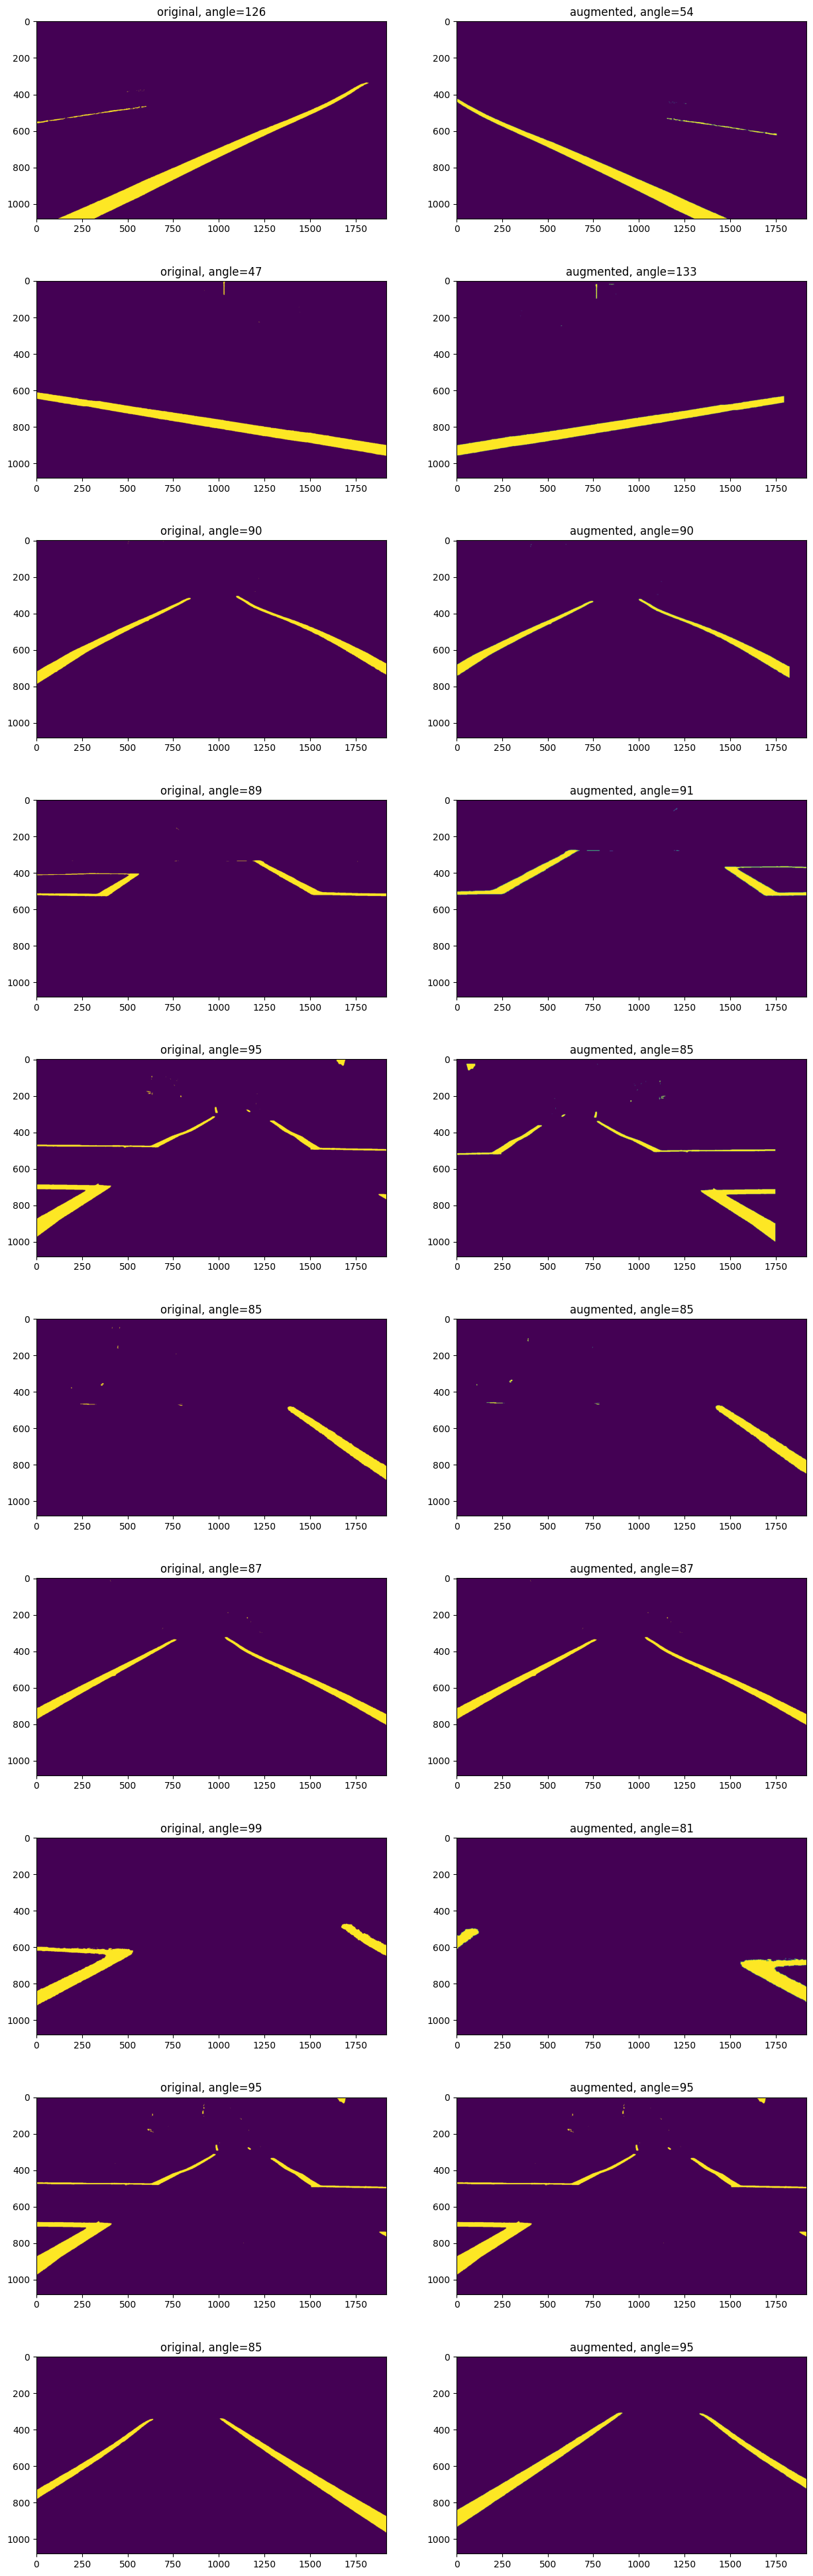

In [13]:
# put it together
def random_augment(image, steering_angle):
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = blur(image)
    if np.random.rand() < 0.5:
        image = adjust_brightness(image)
    image, steering_angle = random_flip(image, steering_angle)
    
    return image, steering_angle

# show a few randomly augmented images
ncol = 2
nrow = 10
fig, axes = plt.subplots(nrow, ncol, figsize=(15, 50))

for i in range(nrow):
    rand_index = random.randint(0, len(image_paths) - 1)
    image_path = image_paths[rand_index]
    steering_angle_orig = steering_angles[rand_index]
    
    image_orig = my_imread(image_path)
    image_aug, steering_angle_aug = random_augment(image_orig, steering_angle_orig)
    
    axes[i][0].imshow(image_orig)
    axes[i][0].set_title("original, angle=%s" % steering_angle_orig)
    axes[i][1].imshow(image_aug)
    axes[i][1].set_title("augmented, angle=%s" % steering_angle_aug)
    

## Preprocess Training Data for Nvidia Model

Text(0.5, 1.0, 'processed')

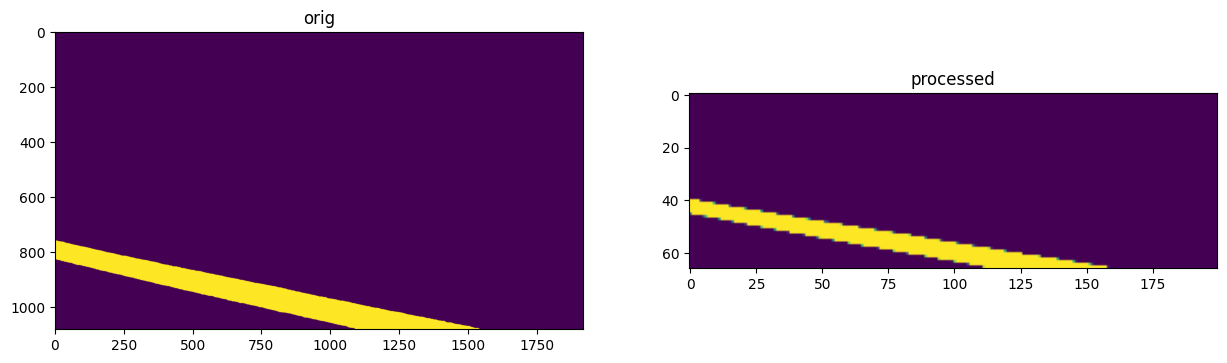

In [14]:
def img_preprocess(image):
    height, _ = image.shape
    image = image[int(height/4):,:]  # remove top half of the image, as it is not relavant for lane following
    image = cv2.GaussianBlur(image, (3,3), 0)
    image = cv2.resize(image, (200,66)) # input image size (200,66) Nvidia model
    image = image / 255 # normalizing, the processed image becomes black for some reason.  do we need this?
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_processed = img_preprocess(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_processed)
axes[1].set_title("processed")


## Create and Train Model

This is the Nvidia CNN Model Architecture. The input layer is at the bottom with size of 200x66 in YUV color space ![](https://github.com/dctian/DeepPiCar/raw/master/models/lane_navigation/doc/NVidia%20Model%20Architecture.JPG) .



In [15]:
def nvidia_model():
    model = Sequential(name='Nvidia_Model')
    
    # Convolutional layers with ELU activation
    model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 1), activation='elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='elu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Conv2D(64, (3, 3), activation='elu'))
    model.add(BatchNormalization())

    # Fully connected layers
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))

    # Output layer (steering angle)
    model.add(Dense(1))

    # Compile model
    optimizer = Adam(learning_rate=1e-4)
    model.compile(loss='mse', optimizer=optimizer)
    
    return model

In [16]:
model = nvidia_model()
print(model.summary())

# check at we will have 252,219 trainable parameters

/Users/tin/TSF-2025-Car/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Nvidia_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 31, 98, 24)     │           624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 31, 98, 24)     │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 47, 36)     │        21,636 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 47, 36)     │           144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 5, 22, 48)      │        43,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 5, 22, 48)      │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 20, 64)      │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 3, 20, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 20, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 1, 18, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1, 18, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       115,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 251,963 (984.23 KB)

 Trainable params: 251,491 (982.39 KB)

 Non-trainable params: 472 (1.84 KB)

None


In [17]:
def image_data_generator(image_paths, steering_angles, batch_size, is_training):
    while True:
        batch_images = []
        batch_steering_angles = []
        
        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
            image_path = image_paths[random_index]
            image = my_imread(image_paths[random_index])
            steering_angle = steering_angles[random_index]
            if is_training:
                # training: augment image
                image, steering_angle = random_augment(image, steering_angle)
              
            image = img_preprocess(image)
            batch_images.append(image)
            batch_steering_angles.append(steering_angle)
            
        yield( np.asarray(batch_images), np.asarray(batch_steering_angles))
            
            

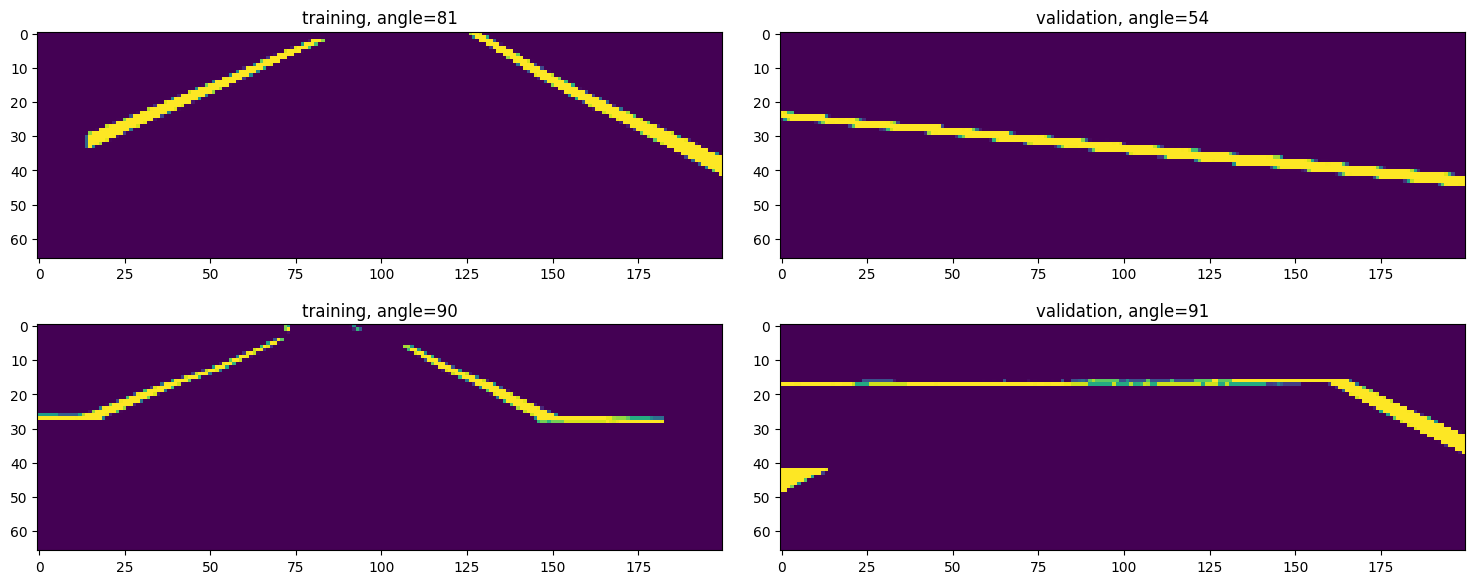

In [18]:
ncol = 2
nrow = 2

X_train_batch, y_train_batch = next(image_data_generator(X_train, y_train, nrow, True))
X_valid_batch, y_valid_batch = next(image_data_generator(X_valid, y_valid, nrow, False))

fig, axes = plt.subplots(nrow, ncol, figsize=(15, 6))
fig.tight_layout()

for i in range(nrow):
    axes[i][0].imshow(X_train_batch[i])
    axes[i][0].set_title("training, angle=%s" % y_train_batch[i])
    axes[i][1].imshow(X_valid_batch[i])
    axes[i][1].set_title("validation, angle=%s" % y_valid_batch[i])


In [19]:
# start Tensorboard before model fit, so we can see the epoch tick in Tensorboard
# Jupyter Notebook embedded Tensorboard is a new feature in TF 2.0!!  

# clean up log folder for tensorboard
log_dir_root = f'{model_output_dir}/logs/'
#!rm -rf $log_dir_root


In [ ]:
# saves the model weights after each epoch if the validation loss decreased
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir,'lane_navigation_check.keras'), verbose=1, save_best_only=True)

SendEmail("lane nav train started")
with tf.device('/cpu:0'):
    history = model.fit(image_data_generator( X_train, y_train, batch_size=100, is_training=True),
                        steps_per_epoch=300,
                        epochs=20,
                        validation_data = image_data_generator( X_valid, y_valid, batch_size=100, is_training=False),
                        validation_steps=200,
                        verbose=1,
                        shuffle=1,
                        callbacks=[checkpoint_callback])
# always save model output as soon as model finishes training
model.save(os.path.join(model_output_dir,'lane_navigation_final.keras'))

date_str = datetime.datetime.now().strftime("%y%m%d_%H%M%S")
history_path = os.path.join(model_output_dir,'history.pickle')
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)
    
SendEmail("lane nav train finished. val_loss from %.1f to %.1f" % (history.history['val_loss'][0], history.history['val_loss'][-1]))


Email Stub: 
lane nav train started
Epoch 1/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 5008.0674
Epoch 1: val_loss improved from inf to 3004.48169, saving model to /Users/tin/AiTestVenv311/test_output_2/lane_navigation_check.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 504s 2s/step - loss: 5000.4404 - val_loss: 3004.4817
Epoch 2/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 319.6529
Epoch 2: val_loss improved from 3004.48169 to 432.48361, saving model to /Users/tin/AiTestVenv311/test_output_2/lane_navigation_check.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 483s 2s/step - loss: 319.4734 - val_loss: 432.4836
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 174.0392
Epoch 3: val_loss improved from 432.48361 to 132.50281, saving model to /Users/tin/AiTestVenv311/test_output_2/lane_navigation_check.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 663s 2s/step - loss: 173.9910 - val_loss: 132.5028
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 139.0574
Epoch 4: val_loss improved from 132.

In [ ]:
model.save(os.path.join(model_output_dir,'lane_navigation_final.keras'))

## Check Trained Model on Validation Data

In [ ]:
history.history


In [ ]:
# plot training and validation losses
# this should be the same as tensorboard
history_path = os.path.join(model_output_dir,'history.pickle')
with open(history_path, 'rb') as f:
    history = pickle.load(f)

In [ ]:
history
plt.plot(history['loss'],color='blue')
plt.plot(history['val_loss'],color='red')
plt.legend(["training loss", "validation loss"])

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score


@keras.saving.register_keras_serializable()
def mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

def summarize_prediction(Y_true, Y_pred):
    
    mse = mean_squared_error(Y_true, Y_pred)
    r_squared = r2_score(Y_true, Y_pred)
    
    print(f'mse       = {mse:.2}')
    print(f'r_squared = {r_squared:.2%}')
    print()
    
def predict_and_summarize(X, Y):
    model = load_model(f'{model_output_dir}/lane_navigation_final.keras')
    Y_pred = model.predict(X)
    summarize_prediction(Y, Y_pred)
    return Y_pred

In [ ]:
n_tests = 100
X_test, y_test = next(image_data_generator(X_valid, y_valid, 100, False))

y_pred = predict_and_summarize(X_test, y_test)

n_tests_show = 5
fig, axes = plt.subplots(n_tests_show, 1, figsize=(10, 4 * n_tests_show))
for i in range(n_tests_show):
    axes[i].imshow(X_test[i])
    axes[i].set_title(f"actual angle={y_test[i]}, predicted angle={int(y_pred[i])}, diff = {int(y_pred[i])-y_test[i]}")
    

As we can see the $R^2$ of the predicted was around 95% and Mean Squared Errors (MSE) are low, indicating the model is predicting a steering angle every simliar to our hand coded land follower, which was used as the model input. 

## References
1. Mariusz Bojarski, Davide Del Testa, Daniel Dworakowski, Bernhard Firner, Beat Flepp, Prasoon Goyal, Lawrence D. Jackel, Mathew Monfort, Urs Muller, Jiakai Zhang, Xin Zhang, Jake Zhao, Karol Zieba (2016) *End to End Learning for Self-Driving Cars*. Nvidia 
1. Rayan Slim, Amer Sharaf, Jad Slim (2017) *The Complete Self-Driving Car Course*. Udemy
1. Keras Documentation (2019) https://github.com/keras-team/keras/

